In [1]:
import ast
from pathlib import Path
import sys
import os
import pickle
import itertools

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib.pyplot import plot
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 12

import matplotlib.dates as mdates

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from nomad import conf, costs
from nomad.costs.nodes import dynamic

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Get all time-dep edge costs
# Read in the supernetwork as an object
graph_sn_path = Path().resolve() / 'graph_sn.pkl'
with open(graph_sn_path, 'rb') as inp:
    G_sn = pickle.load(inp)
df_tt_dynamic, df_rel_dynamic, df_price_dynamic, df_risk_dynamic, df_disc_dynamic = costs.edges.dynamic.assign_edge_costs(G_sn)
df_edge_info = df_tt_dynamic[['source', 'target', 'mode_type']].reset_index(drop=True)

# Make cost array dict
NUM_INTERVALS = conf.NUM_INTERVALS  
interval_columns = [f'i{i}' for i in range(NUM_INTERVALS)]

cost_arrays = {}
cost_arrays['tt'] = df_tt_dynamic[interval_columns].values.astype('float16')
cost_arrays['rel'] = df_rel_dynamic[interval_columns].values.astype('float16')
cost_arrays['price'] = df_price_dynamic[interval_columns].values.astype('float16')
cost_arrays['risk'] = df_risk_dynamic[interval_columns].values.astype('float16')
cost_arrays['disc'] = df_disc_dynamic[interval_columns].values.astype('float16')

In [3]:
INTERVAL_SPACING = conf.INTERVAL_SPACING
td_link_tt = np.around(df_tt_dynamic[interval_columns].values.astype('float') / INTERVAL_SPACING)
# replace zeros with ones (because zeros can mess up TDSP computation)
td_link_tt[td_link_tt == 0] = 1

In [4]:
import gc
del df_tt_dynamic, df_rel_dynamic, df_price_dynamic, df_risk_dynamic, df_disc_dynamic
gc.collect()

44

In [5]:
### Get mappings
node_set = sorted(list(set(df_edge_info['source']).union(set(df_edge_info['target']))))
nid_map = dict(zip(range(len(node_set)), node_set))
inv_nid_map = dict(zip(nid_map.values(), nid_map.keys()))

### Create linkID map and its inverse
linkID_map = dict(zip(df_edge_info.index, tuple(zip((df_edge_info['source']),df_edge_info['target']))  ))
inv_linkID_map = dict(zip(linkID_map.values(), linkID_map.keys()))

In [6]:
df_tdsp = pd.read_csv(Path().resolve() / 'tdsp_results_base_model.csv') 
df_tdsp.columns = ['org', 'dst', 'vot', 'timestamp', 'node_seq', 'link_seq', 'gtc_tot', 'tt_tot']
df_tdsp['node_seq'] = df_tdsp['node_seq'].apply(ast.literal_eval)
df_tdsp['link_seq'] = df_tdsp['link_seq'].apply(ast.literal_eval)

df_sc_price = pd.read_csv(Path().resolve() / 'tdsp_results_sc_prices.csv') 
df_sc_price.columns = ['org', 'dst', 'sc_ppmin', 'timestamp', 'node_seq', 'link_seq', 'gtc_tot', 'tt_tot']
df_sc_price['sc_ppmin'] = df_sc_price['sc_ppmin'].str[2:].astype(float)
df_sc_price['node_seq'] = df_sc_price['node_seq'].apply(ast.literal_eval)
df_sc_price['link_seq'] = df_sc_price['link_seq'].apply(ast.literal_eval)

In [8]:
def get_path_attributes(link_seq, timestamp, cost_arrays, td_link_tt):
    price_total, risk_total, rel_total, tt_total, discomfort_total = 0, 0, 0, 0, 0
    
    t = int(timestamp)

    for l in link_seq:  # the link seq
        # look up how many time intervals it takes to cross the link
        l = int(l) 
        if t >= td_link_tt.shape[1] - 1:   
            t = int(td_link_tt.shape[1] - 1 - 1)  # adjust the time if we reach the last interval
        intervals_cross = td_link_tt[l, t]  

        # # TODO: figure out how to add node costs more efficiently
        # if idx > 0:
        #     node_id = int(node_seq[idx])
        #     in_link_id = int(link_seq[idx-1])
        #     out_link_id = l
        #     #if any(np.equal(nodecost_ids,[node_id, in_link_id, out_link_id]).all(1)):
        #     if [node_id, in_link_id, out_link_id] in nodecost_ids:
        #         nodecost = -2.75 
        #     else:
        #         nodecost = 0
        # else:
        #     nodecost = 0

        price_link, risk_link, rel_link, tt_link, disc_link = cost_arrays['price'][l,t], cost_arrays['risk'][l,t], cost_arrays['rel'][l,t], cost_arrays['tt'][l,t], cost_arrays['disc'][l,t]  # (these arrays do not have a col for linkID)

        #print(nid_map[node_in], nid_map[node_out], round(risk_link/60,3))
        #cost_link = td_link_cost[l,t+1]  # cannot use td_link_cost b/c it only reflects most recently used betas     
        # update time and cost totals
        #print(nid_map[node_in], nid_map[node_out], 'price:', round(price_link,2), 'risk:', round(risk_link,2), 'rel:', round(rel_link/60,2), 'tt:',round(tt_link/60,2), 'discomf:',round(discomfort_link,2))
        price_total += price_link #+ nodecost
        risk_total += risk_link
        rel_total += rel_link
        tt_total += tt_link
        discomfort_total += disc_link
        #cost_total += cost_link
        t = int(t + intervals_cross)  

    return (tt_total, rel_total, price_total, risk_total, discomfort_total)

In [9]:
BETAS = {
    'rel': 10/3600,
    'x': 1,
    'risk': 20,
    'disc': 0}
df_tdsp[['tt_total', 'rel_total', 'price_total', 'risk_total', 'disc_total']] = df_tdsp.apply(lambda row: get_path_attributes(row['link_seq'], row['timestamp'], cost_arrays, td_link_tt), axis=1, result_type='expand')
# Manually adjust the price of single and double transfer trips
# We should do this in previous step, but it takes too long to do "properly"
df_tdsp.loc[df_tdsp['price_total'].isin([5.50,8.25]), 'price_total'] = 2.75
# calc GTC
df_tdsp['gtc_calc'] = df_tdsp['vot']/3600 *df_tdsp['tt_tot'] + BETAS['rel']*df_tdsp['rel_total'] + BETAS['x']*df_tdsp['price_total'] + BETAS['risk']*df_tdsp['risk_total'] + BETAS['disc']*df_tdsp['disc_total']

In [10]:
def get_named_path(node_seq, nid_map):
    int_path = [int(n) for n in node_seq]
    path_named = [nid_map[n] for n in int_path]
    return path_named
def get_path_modes(named_path):
    stripped_path = [n[0] for n in named_path]
    mode_count = {}
    for m in ['t','r','b','s']:  # tnc, route, bikeshare, scooter, zip
        mode_count[m] = stripped_path.count(m)
    modes_in_path = []
    for m, count in mode_count.items():
        if count > 1:
            modes_in_path.append(m)
    return tuple(sorted(list(set(modes_in_path))))
def convert_timestamp(timestamp, start_hour, start_minute):
    '''Convert timestamp to HH:MM representation.'''
    # Calc minutes since start time
    total_minutes = (timestamp // 6) + (start_hour * 60 + start_minute)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:01}:{minutes:02}"

for df in [df_tdsp, df_sc_price]:
    df[['tt_total', 'rel_total', 'price_total', 'risk_total', 'disc_total']] = df.apply(lambda row: get_path_attributes(row['link_seq'], row['timestamp'], cost_arrays, td_link_tt), axis=1, result_type='expand')
    df.loc[df['price_total'].isin([5.50,8.25]), 'price_total'] = 2.75
    df['named_path'] = df.apply(lambda row: get_named_path(row['node_seq'], nid_map), axis=1)
    df['path_modes_abbrev'] = df.apply(lambda row: get_path_modes(row['named_path']), axis=1)
    mode_abbrev_map = {('b',):'bikeshare / walk', ('r',):'public transit / walk', ('b', 'r'):'public transit / bikeshare / walk', ('b', 'r', 's'): 'public transit / scooter / bikeshare / walk',
                        ('r', 's'):'public transit / scooter / walk', ('t',):'TNC / walk', ('b','s'): 'scooter / bikeshare / walk', ('s',): 'scooter / walk'}
    df['path_modes_full'] = df['path_modes_abbrev'].apply(lambda x: mode_abbrev_map.get(x, 'Unknown'))
    df['departure_time_str'] = df.apply(lambda row: convert_timestamp(row['timestamp'], 7, 0), axis=1)
    df['tt_min'] = round(df['tt_total']/60, 2)
    df['tt_min_dot'] = df['tt_tot'] * 10 / 60
    df['departure_time'] = pd.to_datetime(df['departure_time_str'], format='%H:%M')


org5648002
org5623003


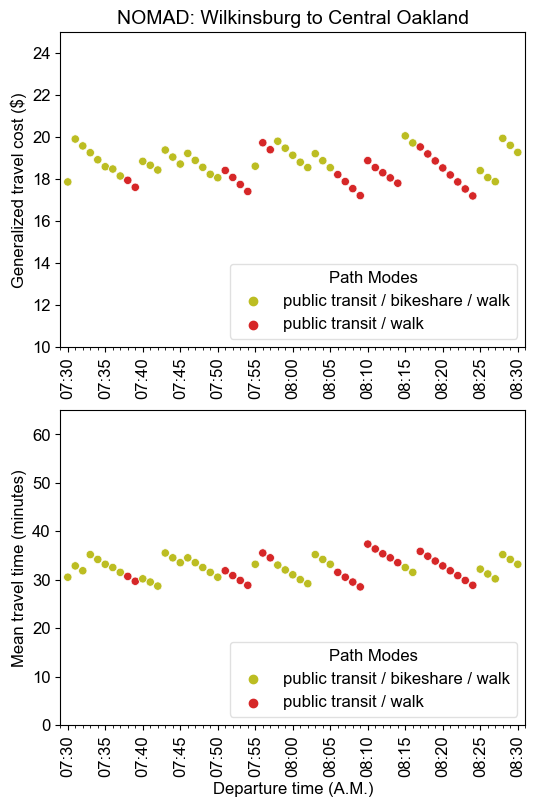

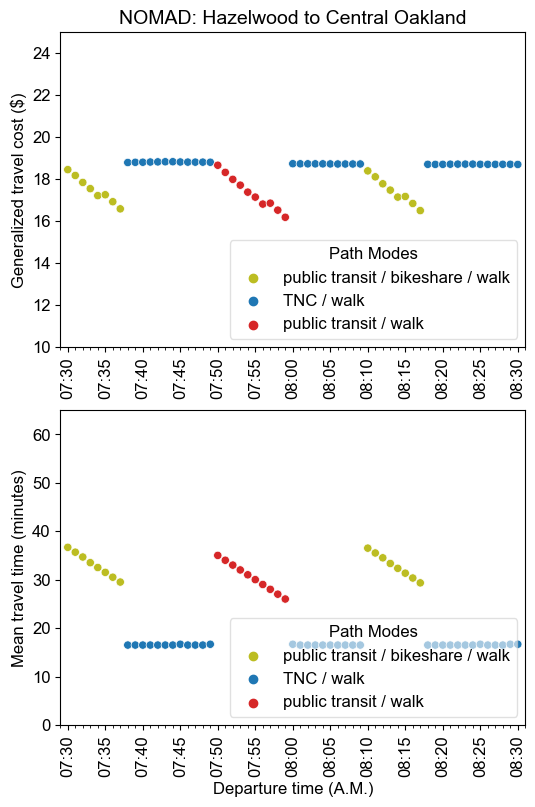

In [12]:
od_pairs = list(itertools.product(df_tdsp['org'].unique().tolist(), df_tdsp['dst'].unique().tolist()))

nid_map[od_pairs[1][0]]
#df_od.head(10)
palette = dict(zip(list(mode_abbrev_map.values()), ['black', 'tab:red', 'tab:olive', 'darkgreen', 'darkorange', 'tab:blue', 'gray', 'purple']))
vot = 10
nhoods = ['Wilkinsburg', 'Hazelwood']
dst = 'Central Oakland'

nrows, ncols = 2,1
for k, od in enumerate([1,4]):  # [Wilkinsburg, Glen Hazel]
    print(nid_map[od_pairs[od][0]])
    df_od = df_tdsp[(df_tdsp['org'] == od_pairs[od][0]) & (df_tdsp['dst'] == od_pairs[od][1]) & (df_tdsp['vot'] == vot)]

    fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,9))
    sns.scatterplot(ax=ax[0], x='departure_time', y='gtc_tot', data=df_od[df_od['timestamp'].between(180,541)], hue='path_modes_full', palette=palette)
    ax[0].set_ylabel('Generalized travel cost ($)')
    ax[0].set_ylim([10,25])
    sns.scatterplot(ax=ax[1], x='departure_time', y='tt_min_dot', data=df_od[df_od['timestamp'].between(180,541)], hue='path_modes_full', palette=palette)
    ax[1].set_ylabel('Mean travel time (minutes)')
    ax[1].set_ylim([0,65])
    ax[0].set_title('NOMAD: ' + nhoods[k] + ' to ' + dst)

    for i in range(nrows):
        ax[i].xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0,70,5)))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[i].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0,70,1)))
        ax[i].tick_params(axis='x', rotation=90)
        ax[i].set_xlim([pd.to_datetime('07:29',format='%H:%M'), pd.to_datetime('08:31', format='%H:%M')])
        ax[i].margins(x=10)
        #ax.set_yticks(np.arange(22,26,0.5))
        legend = ax[i].legend(title='Path Modes', fontsize=10)
        sns.move_legend(ax[i], 'lower right')
        legend = ax[i].get_legend()
        legend.get_frame().set_alpha(0.6)
    ax[0].set_xlabel('')
    ax[1].set_xlabel('Departure time (A.M.)')
        
plt.show();

In [19]:
od = 1
sc_ppmin = 0.19
df_od = df_sc_price[(df_sc_price['org'] == od_pairs[od][0]) & (df_sc_price['dst'] == od_pairs[od][1]) & (df_sc_price['sc_ppmin'] == sc_ppmin) & (df_od['timestamp'].between(181,540))]

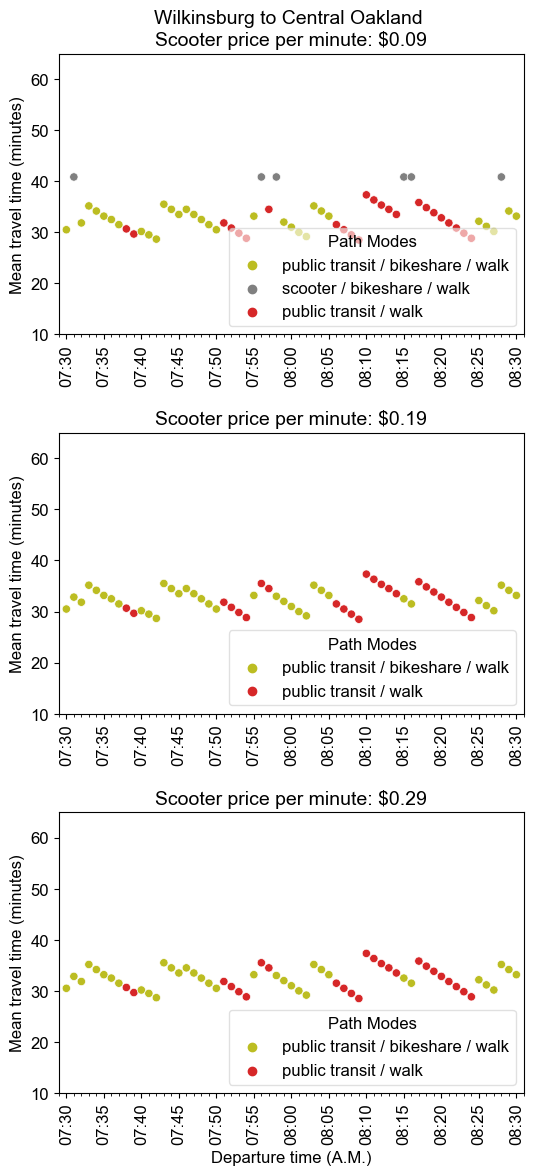

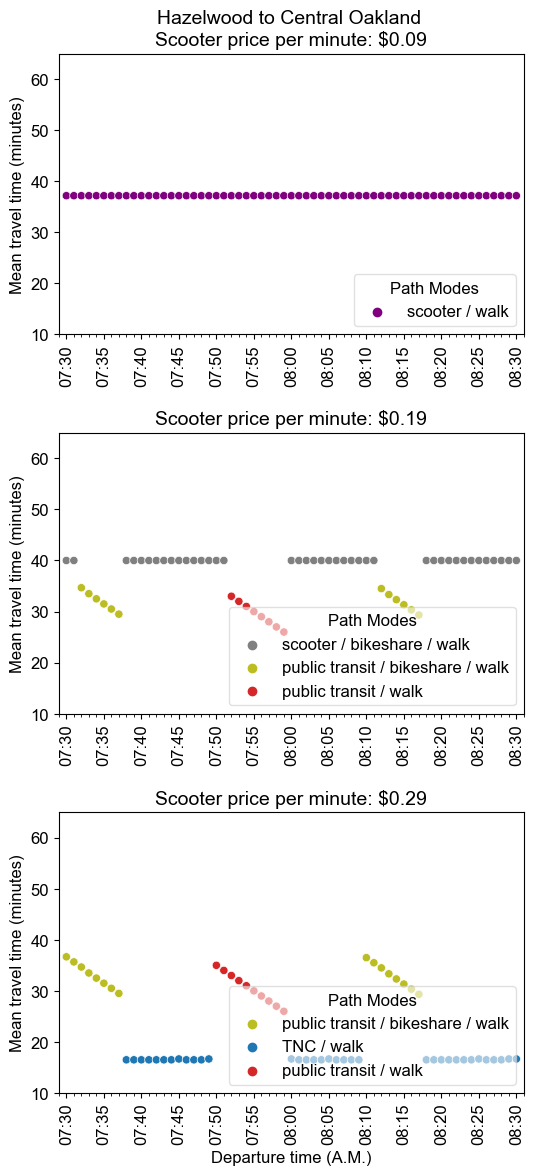

In [31]:
nid_map[od_pairs[1][0]]
#df_od.head(10)

vot = 10

od = 4
sc_prices = [0.09, 0.19, 0.29]
nrows = len(sc_prices)
ncols = 1
nhoods_dict = {1: 'Wilkinsburg', 4: 'Hazelwood'}

for od in [1,4]:
    fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6,13.5))
    plt.subplots_adjust(hspace=0.35)
    for i, sc_ppmin in enumerate(sc_prices): 
        df_od = df_sc_price[(df_sc_price['org'] == od_pairs[od][0]) & (df_sc_price['dst'] == od_pairs[od][1]) & (df_sc_price['sc_ppmin'] == sc_ppmin)]
        # sns.scatterplot(ax=ax[i,0], x='departure_time', y='gtc_tot', data=df_od[df_od['timestamp'].between(180,541)], hue='path_modes_full', palette=palette)
        # ax[i,0].set_ylabel('Generalized travel cost ($)')
        # ax[i,0].set_ylim([10,30])
        sns.scatterplot(ax=ax[i], x='departure_time', y='tt_min_dot', data=df_od[df_od['timestamp'].between(180,541)], hue='path_modes_full', palette=palette)
        ax[i].set_ylabel('Mean travel time (minutes)')
        ax[i].set_ylim([10,65])
        #for in range(ncols):
        ax[i].xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0,70,5)))
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[i].xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0,70,1)))
        ax[i].tick_params(axis='x', rotation=90)
        ax[i].set_xlim([pd.to_datetime('07:29',format='%H:%M'), pd.to_datetime('08:31', format='%H:%M')])
        ax[i].margins(x=10)
        if i == 0:
            ax[i].set_title(nhoods_dict[od] + ' to Central Oakland \n' + 'Scooter price per minute: $' + str(sc_ppmin))
            ax[i].set_xlabel('')
        elif i == 1:
            ax[i].set_title('Scooter price per minute: $' + str(sc_ppmin))
            ax[i].set_xlabel('')
        elif i == 2:
            ax[i].set_title('Scooter price per minute: $' + str(sc_ppmin))
            ax[i].set_xlabel('Departure time (A.M.)')        
            #ax.set_yticks(np.arange(22,26,0.5))
        legend = ax[i].legend(title='Path Modes')
        sns.move_legend(ax[i], 'lower right')
        legend = ax[i].get_legend()
        legend.get_frame().set_alpha(0.6)
        
plt.show();

<AxesSubplot: >

<AxesSubplot: >

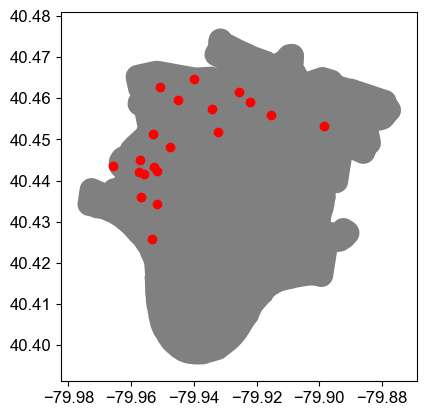

In [22]:

# read in bikeshare depot locations and build connection edges
df_bs = pd.read_csv(conf.bikeshare_station_path)
# generate point geometry from x,y coords, so that the GIS clip function can be used to only include depots within the study region
df_bs['geometry'] = gpd.points_from_xy(df_bs['Longitude'], df_bs['Latitude'], crs="EPSG:4326")
gdf_bs = gpd.GeoDataFrame(df_bs)  # convert to geo df
gdf_bs['pos'] = tuple(zip(gdf_bs['Longitude'], gdf_bs['Latitude']))  # add position

# Clip the bs node network
# study_area_gdf = gpd.read_file(os.path.join(os.path.join(os.getcwd(), 'Data', 'Output_Data'), 'study_area.csv'))
# # Check 
# fig,ax = plt.subplots()
# study_area_gdf.plot(ax=ax)
# gdf_bs.plot(ax=ax, color='black')
study_area_gdf = gpd.read_file(conf.study_area_outpath)
gdf_bs_clip = gpd.clip(gdf_bs, study_area_gdf).reset_index()
fig, ax = plt.subplots()
study_area_gdf.plot(ax=ax, color='gray')
gdf_bs_clip.plot(ax=ax, color='red')

In [1]:
# dept_time = '8:15'  # **choose 8am**
# od = 4
# df = df_tdsp[(df_tdsp['org'] == od_pairs[od][0]) & (df_tdsp['dst'] == od_pairs[od][1]) & (df_tdsp['departure_time_str'] == dept_time)]
# df[['named_path', 'price_total', 'risk_total']].head(10)
# for vot, p in zip(df.vot, df.named_path):
#         print(vot, p)
# #G_sn.graph.nodes['org5623003']

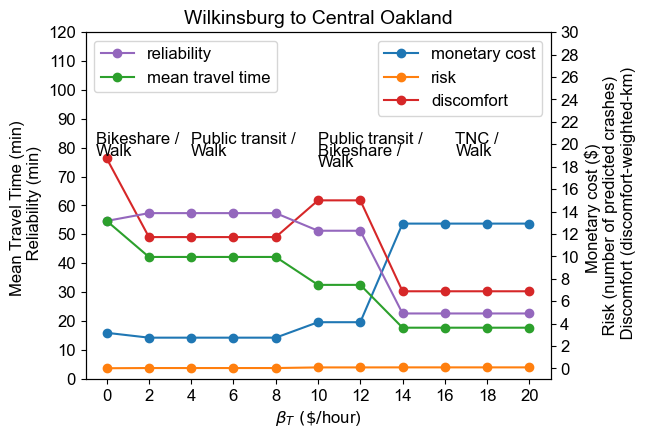

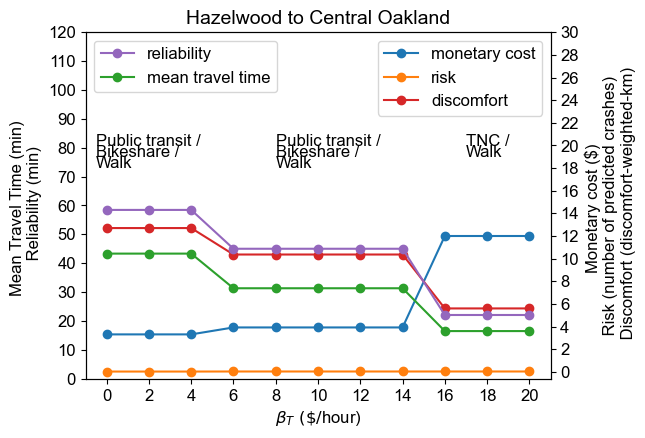

In [37]:
od = 1  # {1: 'Wilkinsburg', 3: 'Glen Hazel'}

dept_time = '8:15'  
for od in [1,4]:
    df_vot = df_tdsp[(df_tdsp['org'] == od_pairs[od][0]) & (df_tdsp['dst'] == od_pairs[od][1]) & (df_tdsp['departure_time_str'] == dept_time)]

    # Adjust vot, show the cost attributes
    x_axis = df_tdsp['vot'].unique()
    fig, ax1 = plt.subplots(figsize=(6,4.5))
    ax2 = ax1.twinx()
    # Plot points
    # Left axis
    ax1.plot(x_axis, round(df_vot['rel_total']/60, 2), label='reliability', color='C4', marker='o')
    ax1.plot(x_axis, round(df_vot['tt_min_dot'], 2), label='mean travel time', color='C2', marker='o')
    # Right axis
    ax2.plot(x_axis, df_vot['price_total'], label='monetary cost', color='C0', marker='o')
    ax2.plot(x_axis, df_vot['risk_total'], label='risk', color='C1', marker='o')
    ax2.plot(x_axis, df_vot['disc_total'], label='discomfort', color='C3', marker='o')
    # x and y axis ticks
    ax2.set_xticks(np.arange(0,22,2), fontsize=10)
    ax1.set_yticks(np.arange(0,130,10), fontsize=6)
    ax2.set_yticks(np.arange(0,32,2), fontsize=6)
    # Set x and y labels
    ax1.set_ylabel('Mean Travel Time (min) \n Reliability (min)')
    ax2.set_ylabel('Monetary cost ($) \n Risk (number of predicted crashes) \n Discomfort (discomfort-weighted-km)')
    # Legend
    ax2.legend(loc='upper right')
    ax1.legend(loc='upper left')
    ax1.set_xlabel(r'$\beta_{T}\ (\$/$hour)')

    fontsize = 'large'
    if od == 1:
        ax1.set_zorder(2)
        ax2.set_zorder(1)
        ax1.patch.set_visible(False)
        # distinguish region by mode type
        h3 = 18
        h2 = 19
        h1 = 20
        ax2.text(-0.5,h1,'Bikeshare /',fontsize=fontsize, zorder=3)
        ax2.text(-0.5,h2,'Walk',fontsize=fontsize, zorder=3)
        ax2.text(4,h1,'Public transit /',fontsize=fontsize, zorder=3)
        ax2.text(4,h2,'Walk',fontsize=fontsize, zorder=3)
        ax2.text(10,h1,'Public transit /',fontsize=fontsize, zorder=3)
        ax2.text(10,h2,'Bikeshare /',fontsize=fontsize, zorder=3)
        ax2.text(10,h3,'Walk',fontsize=fontsize, zorder=3)
        ax2.text(16.5,h1,'TNC /',fontsize=fontsize, zorder=3)
        ax2.text(16.5,h2,'Walk',fontsize=fontsize, zorder=3)
        ax1.set_title('Wilkinsburg to Central Oakland')
    
    if od == 4:
        ax1.set_zorder(2)
        ax2.set_zorder(1)
        ax1.patch.set_visible(False)
        # distinguish region by mode type
        h3 = 18
        h2 = 19
        h1 = 20
        ax2.text(-0.5,h1,'Public transit /',fontsize=fontsize, zorder=3)
        ax2.text(-0.5,h2,'Bikeshare /',fontsize=fontsize, zorder=3)
        ax2.text(-0.5,h3,'Walk',fontsize=fontsize, zorder=3)
        ax2.text(8,h1,'Public transit /',fontsize=fontsize, zorder=3)
        ax2.text(8,h2,'Bikeshare /',fontsize=fontsize, zorder=3)
        ax2.text(8,h3,'Walk',fontsize=fontsize, zorder=3)
        ax2.text(17,h1,'TNC /',fontsize=fontsize, zorder=3)
        ax2.text(17,h2,'Walk',fontsize=fontsize, zorder=3)
        ax1.set_title('Hazelwood to Central Oakland')
plt.show();

In [11]:
def get_nid_map(G):
    df_edge_info = costs.edges.nx_to_df(G)
    node_set = sorted(list(set(df_edge_info['source']).union(set(df_edge_info['target']))))
    nid_map = dict(zip(range(len(node_set)), node_set))
    return nid_map

In [12]:
from collections import defaultdict
od_matrix_pt = pd.read_csv('od_matrix_pt.csv', delimiter=',')
od_matrix_pt_bs = pd.read_csv('od_matrix_pt_bs.csv', delimiter=',')

od_matrix_pt['node_seq'] = od_matrix_pt['node_seq'].apply(ast.literal_eval)
od_matrix_pt['link_seq'] = od_matrix_pt['link_seq'].apply(ast.literal_eval)

od_matrix_pt_bs['node_seq'] = od_matrix_pt_bs['node_seq'].apply(ast.literal_eval)
od_matrix_pt_bs['link_seq'] = od_matrix_pt_bs['link_seq'].apply(ast.literal_eval)

graphs = defaultdict(dict)

mode_list = ['pt', 'pt_bs']
for m in mode_list:
    # Read in the supernetwork as an object
    graph_path = Path().resolve() / f'graph_{m}.pkl'
    with open(graph_path, 'rb') as inp:
        graphs[m]['graph'] =  pickle.load(inp)
    graphs[m]['nid_map'] = get_nid_map(graphs[m]['graph'])
    graphs[m]['inv_nid_map'] = dict(zip(graphs[m]['nid_map'].values(), graphs[m]['nid_map'].keys()))

graphs['pt']["od_matrix"] = od_matrix_pt
graphs['pt_bs']["od_matrix"] = od_matrix_pt_bs

In [13]:
graphs['pt']['td_link_tt'] = np.loadtxt(Path().resolve() / 'tdsp_files_pt' / 'td_link_tt', skiprows=1)
graphs['pt_bs']['td_link_tt'] = np.loadtxt(Path().resolve() / 'tdsp_files_pt_bs' / 'td_link_tt', skiprows=1)

In [14]:
import gc

for m in mode_list:
    df_tt_dynamic, df_rel_dynamic, df_price_dynamic, df_risk_dynamic, df_disc_dynamic = costs.edges.dynamic.assign_edge_costs(graphs[m]['graph'])
    df_edge_info = df_tt_dynamic[['source', 'target', 'mode_type']].reset_index(drop=True)

    # Make cost array dict
    NUM_INTERVALS = conf.NUM_INTERVALS  
    interval_columns = [f'i{i}' for i in range(NUM_INTERVALS)]

    cost_arrays = {}
    cost_arrays['tt'] = df_tt_dynamic[interval_columns].values.astype('float16')
    cost_arrays['rel'] = df_rel_dynamic[interval_columns].values.astype('float16')
    cost_arrays['price'] = df_price_dynamic[interval_columns].values.astype('float16')
    cost_arrays['risk'] = df_risk_dynamic[interval_columns].values.astype('float16')
    cost_arrays['disc'] = df_disc_dynamic[interval_columns].values.astype('float16')

    del df_tt_dynamic, df_rel_dynamic, df_price_dynamic, df_risk_dynamic, df_disc_dynamic
    gc.collect()

    od_matrix = graphs[m]['od_matrix']
    od_matrix[['tt_total', 'rel_total', 'price_total', 'risk_total', 'disc_total']] = od_matrix.apply(lambda row: get_path_attributes(row['link_seq'], row['timestamp'], cost_arrays, graphs[m]['td_link_tt']), axis=1, result_type='expand')
    
    od_matrix['org_name'] = od_matrix['org'].map(graphs[m]['nid_map'])
    od_matrix['dst_name'] = od_matrix['dst'].map(graphs[m]['nid_map'])
    graphs[m]['od_matrix'] = od_matrix

44

22

In [15]:
# preprocessing of dst df
dst_centroids_gdf = gpd.read_file(conf.opp_jobs_path)
dst_centroids_gdf['dst_name'] = 'dst' + dst_centroids_gdf['GEOID'].str[5:]
dst_centroids_gdf['opp_jobs_total'] = dst_centroids_gdf['opp_jobs_total'].fillna(0)

/home/lgraff/ENTER/envs/py39/lib/python3.9/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


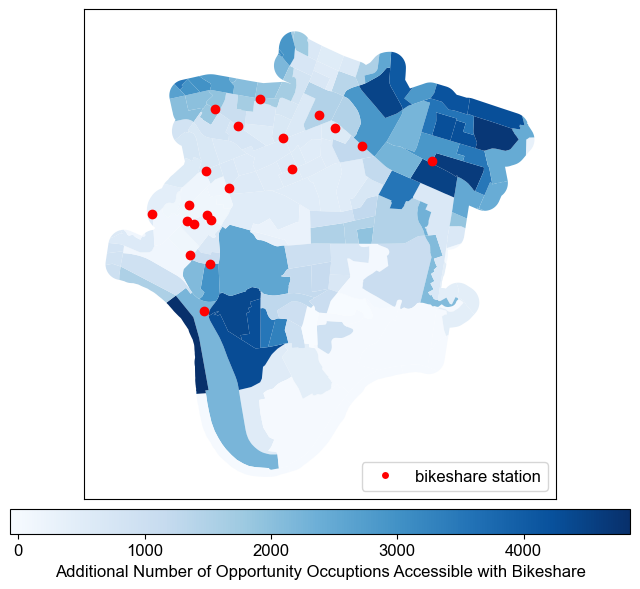

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def calc_cum_opps(df_od_matrix, cost_col, df_dsts, opp_col_name, TT_THRESHOLD):
    df_access = pd.merge(df_od_matrix, df_dsts[['dst_name', opp_col_name]], how='left', on='dst_name')
    df_access['tt_min'] = df_access['tt_tot'] * conf.INTERVAL_SPACING / 60
    df_access['rel_min'] = df_access['rel_total'] / 60
    # Get the median travel time during the interval
    df_median = df_access.groupby(['org_name','dst_name'])[['tt_min', 'rel_min', opp_col_name]].median().reset_index()
    df_median['access_ind'] = (df_median[cost_col] <= TT_THRESHOLD).astype(int)
    df_median['access_jobs'] = df_median['access_ind'] * df_median['opp_jobs_total']
    df_cum_opps = df_median.groupby('org_name')['access_jobs'].sum().reset_index()
    return df_cum_opps

TT_THRESHOLD = 60 # minutes
for m in mode_list:
    df_cum_opps = calc_cum_opps(graphs[m]['od_matrix'], 'rel_min', dst_centroids_gdf, 'opp_jobs_total', TT_THRESHOLD)
    graphs[m]['cum_opps'] = df_cum_opps

df_cum_opps = pd.merge(graphs['pt']['cum_opps'], graphs['pt_bs']['cum_opps'], how='inner', on='org_name', suffixes=['_pt', '_pt_bs'])
df_cum_opps['diff'] = df_cum_opps['access_jobs_pt_bs'] - df_cum_opps['access_jobs_pt']

gdf_pop = gpd.read_file(conf.eligible_pop_path)
gdf_pop['GEOID'] = gdf_pop['GEOID'].astype(str)
gdf_pop['org_geo'] = gdf_pop['GEOID'].str[5:]
gdf_pop['org_name'] = 'org' + gdf_pop['org_geo']
df_cum_opps = gpd.GeoDataFrame(pd.merge(df_cum_opps, gdf_pop[['org_name','geometry']], how='right', on='org_name'))

fig, ax = plt.subplots(figsize=(8,8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
df_cum_opps[~df_cum_opps.isna()].plot(ax=ax, column='diff', legend=True, cax=cax, legend_kwds={"label": "Additional Number of Opportunity Occuptions Accessible with Bikeshare", "orientation":"horizontal"},
                 cmap='Blues')
none_elig_gdf = df_cum_opps[df_cum_opps['diff'].isna()]
none_elig_gdf.plot(ax=ax, color='lightgray')
# Bikeshare
study_area_gdf = gpd.read_file(conf.study_area_outpath)
bikeshare_path = conf.bikeshare_station_path
df_bs = pd.read_csv(bikeshare_path)
long_colname, lat_colname = 'Longitude', 'Latitude'
df_bs['geometry'] = gpd.points_from_xy(df_bs[long_colname], df_bs[lat_colname], crs="EPSG:4326")
gdf_bs = gpd.GeoDataFrame(df_bs)  # convert to geo df
bikeshare_clip = gpd.clip(gdf_bs, study_area_gdf).reset_index()
bikeshare_clip.plot(ax=ax, color='red')
#legend_elements = [plt.Line2D([0],[0], marker='s', color='w', markerfacecolor='gray', label='origin not selected \n for analysis'),
#                   plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='red', label='bikeshare station')]
legend_elements = [plt.Line2D([0],[0], marker='o', color='w', markerfacecolor='red', label='bikeshare station')]
ax.legend(handles=legend_elements, loc='lower right')
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
plt.show();


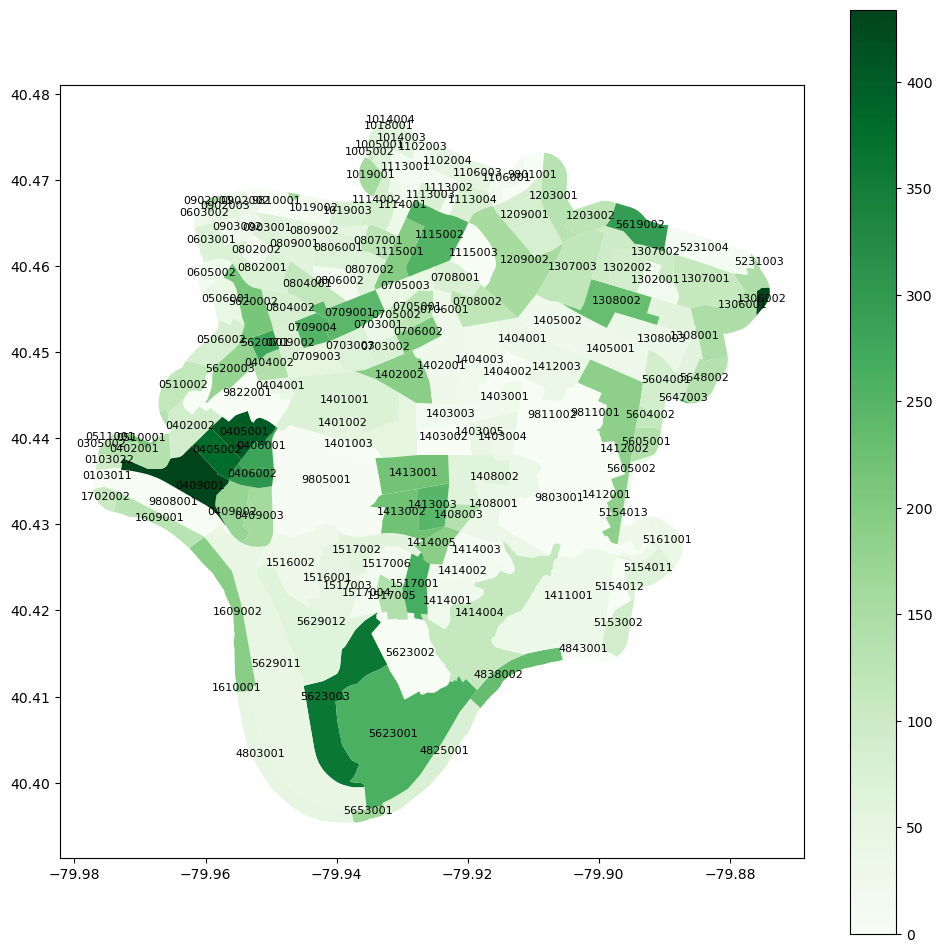

In [6]:
# Construct a heatmap of the total number of adult residents in poverty by block group
gdf_pop = gpd.read_file(conf.eligible_pop_path)
gdf_pop['GEOID'] = gdf_pop['GEOID'].astype(str)
gdf_pop['org_geo'] = gdf_pop['GEOID'].str[5:]
gdf_pop['org'] = 'org' + gdf_pop['org_geo']

gdf_pop['coords'] = gdf_pop['geometry'].apply(lambda x: x.representative_point().coords[:])
gdf_pop['coords'] = [coords[0] for coords in gdf_pop['coords']]

fig,ax = plt.subplots(figsize=(12,12))
gdf_pop.plot(ax=ax, column='total_eligible', cmap='Greens', legend=True);
for idx, row in gdf_pop.iterrows(): #gdf_pop[~gdf_pop['org_idx'].isna()].iterrows():
    plt.annotate(text=str(row['org_geo']), xy=row['coords'], fontsize=8,
                 horizontalalignment='center');

plt.show();
